# Exploring Dandiset 001433: Breathing rhythm and place dataset

**AI-generated notebook (not fully verified): Please be cautious when interpreting code and results. Always review the code and documentation yourself before making any scientific claims.**

---

This notebook provides an overview and exploratory analysis of Dandiset [001433, version 0.250507.2356](https://dandiarchive.org/dandiset/001433/0.250507.2356): **Breathing rhythm and place dataset**.

- **Description:** Behavioral and electrophysiological data from recordings of sniffing, video, and olfactory bulb (OB) electrophysiology in freely-behaving mice given no stimulus, reward, or task.
- **Contributors:** National Institutes of Health (NIH), Matt Smear
- **Institute:** University of Oregon (Smear lab)
- **Techniques:** Multi-electrode extracellular electrophysiology, surgical methods, behavioral analysis
- **Citation:** Breathing rhythm and place dataset (2025). (Version 0.250507.2356) [Data set]. DANDI Archive. https://doi.org/10.48324/dandi.001433/0.250507.2356

This notebook will:
- Show how to load a Dandiset using the DANDI API
- Explore the structure of the NWB files
- Demonstrate how to access and visualize LFP and sniffing signals, and event timing data
- Summarize the found data structures and provide links to online visualization tools

---

## Required packages

This notebook assumes the following packages are **already installed**:

- numpy
- pandas
- matplotlib
- pynwb
- h5py
- dandi
- remfile
- seaborn

Do NOT run any pip install commands here—these are assumed available in your environment.

---

## Load and Explore Dandiset Metadata

We first use the DANDI API to access the Dandiset and summarize its overall contents.

In [1]:
from dandi.dandiapi import DandiAPIClient
from itertools import islice

client = DandiAPIClient()
dandiset = client.get_dandiset("001433", "0.250507.2356")

metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset description: {metadata['description']}")
print(f"Contributors: {', '.join(metadata['contributor'])}")
print(f"Version: {metadata['version']}")
print(f"URL: {metadata['identifier']}")
print(f"Citation: {metadata['citation']}")
print(f"Techniques: {[t['name'] for t in metadata['measurementTechnique']]}")
print("Measured variables:", metadata.get('variableMeasured', []))

assets = dandiset.get_assets()
print("\\nFirst 5 assets:")
for asset in islice(assets, 5):
    print(f"- {asset.path} (ID: {asset.identifier})")

Dandiset name: Breathing rhythm and place dataset
Dandiset description: These are behavioral and electrophysiological data from recordings of sniffing, video, and OB electrophysiology in freely-behaving mice given no stimulus, reward, or task. 1 1 R01 NS 123903


TypeError: sequence item 0: expected str instance, dict found

---
## Choosing an NWB File

For illustration, we'll focus on the file:

**Path:** `sub-4122/sub-4122_ses-20250507T152927_ecephys.nwb`  
**Asset ID:** `63d19f03-2a35-48bd-a54f-9ab98ceb7be2`  

The direct download URL is:  
[https://api.dandiarchive.org/api/assets/63d19f03-2a35-48bd-a54f-9ab98ceb7be2/download/](https://api.dandiarchive.org/api/assets/63d19f03-2a35-48bd-a54f-9ab98ceb7be2/download/)

You can also explore this NWB file directly on [Neurosift](https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/63d19f03-2a35-48bd-a54f-9ab98ceb7be2/download/&dandisetId=001433&dandisetVersion=draft).

## Loading the NWB File with PyNWB (remfile/h5py)

All data exploration and analysis below will use this file and URL.  
We first load the file remotely (do not download!) via PyNWB, remfile, and h5py.

In [2]:
import pynwb
import h5py
import remfile

url = "https://api.dandiarchive.org/api/assets/63d19f03-2a35-48bd-a54f-9ab98ceb7be2/download/"
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

print("NWB session description:", nwb.session_description)
print("NWB identifier:", nwb.identifier)
print("Session start time:", nwb.session_start_time)
print("Experiment description:", nwb.experiment_description)
print("Lab:", nwb.lab)
print("Institution:", nwb.institution)
if hasattr(nwb, "subject") and nwb.subject:
    print("Subject ID:", nwb.subject.subject_id)
    print("Species:", nwb.subject.species)
    print("Sex:", nwb.subject.sex)
    print("Age:", nwb.subject.age)

NWB session description: LFP and sniff recording
NWB identifier: 4122_4
Session start time: 2025-05-07 15:29:27.359523-07:00
Experiment description: LFP and sniff behavior recording
Lab: Smear lab
Institution: University of Oregon
Subject ID: 4122
Species: Mus musculus
Sex: M
Age: P90D


/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


---
## NWB File Structure Overview

The file contains two key types of raw data:

- **LFP (acquisition["LFP"])**: Local Field Potential signals (16 channels, 1kHz sampling rate)
- **SniffSignal (acquisition["SniffSignal"])**: Sniffing sensor signal (1kHz)

Main associated metadata:

```
nwb.identifier:             4122_4
nwb.session_start_time:     2025-05-07T15:29:27-07:00
nwb.subject:
  subject_id:               4122
  description:              Lab mouse used for sniffing + LFP experiment
  age:                      P90D (postnatal day 90)
  sex:                      M
  species:                  Mus musculus
nwb.lab:                    Smear lab
nwb.institution:            University of Oregon
```

Main groups and their organization:

```
Root
├─ acquisition
│  ├─ LFP (ElectricalSeries, shape: [1969184, 16], unit: volts)
│  └─ SniffSignal (TimeSeries, shape: [1969184], unit: volts)
├─ processing
│  └─ behavior
│     ├─ exhalation_time (TimeSeries, 10030 events)
│     └─ inhalation_time (TimeSeries, 10030 events)
├─ electrodes (metadata table, 16 channels)
└─ electrode_groups
    └─ LFPGroup (Olfactory Bulb, OpenEphys system)
```
For full field and table names, see the code below.

### Electrode Metadata Table

The file stores metadata about each electrode in a pandas DataFrame accessible as follows:

In [3]:
electrodes_df = nwb.electrodes.to_dataframe()
display(electrodes_df.head())

,location,group,group_name,filtering
id,,,,
0,olfactory bulb,LFPGroup pynwb.ecephys.ElectrodeGroup at 0x129...,LFPGroup,none
1,olfactory bulb,LFPGroup pynwb.ecephys.ElectrodeGroup at 0x129...,LFPGroup,none
2,olfactory bulb,LFPGroup pynwb.ecephys.ElectrodeGroup at 0x129...,LFPGroup,none
3,olfactory bulb,LFPGroup pynwb.ecephys.ElectrodeGroup at 0x129...,LFPGroup,none
4,olfactory bulb,LFPGroup pynwb.ecephys.ElectrodeGroup at 0x129...,LFPGroup,none


---
## Visualizing the LFP: Local Field Potential Signal

The LFP data is stored in `acquisition['LFP']` and contains shape (1969184, 16):  
1,969,184 timepoints × 16 channels, sampled at 1000 Hz.  

**Note:** To keep things efficient, we'll only plot a small segment (first 5 seconds) of the first 4 LFP channels.

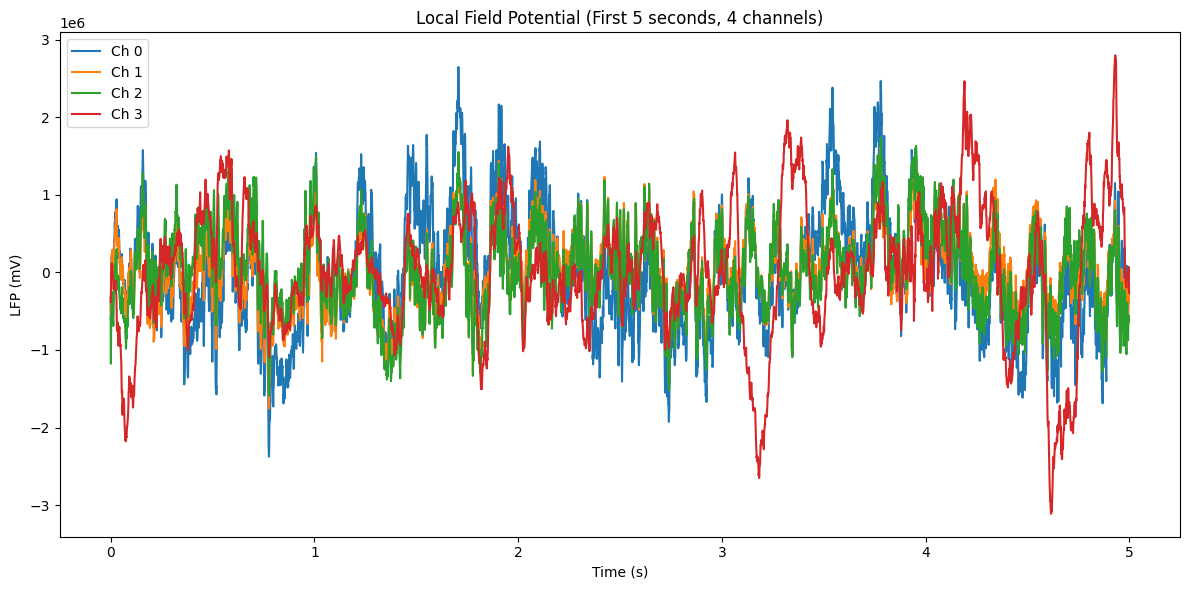

In [4]:
import numpy as np
import matplotlib.pyplot as plt

LFP = nwb.acquisition["LFP"]
rate = LFP.rate
duration_sec = 5  # Plot first 5 seconds
num_samples = int(duration_sec * rate)
channels_to_plot = [0, 1, 2, 3]

time = np.arange(num_samples) / rate
# Load only the required segment from the remote file
lfp_segment = LFP.data[:num_samples, channels_to_plot]

plt.figure(figsize=(12, 6))
for i, ch in enumerate(channels_to_plot):
    plt.plot(time, lfp_segment[:, i] * 1e3, label=f"Ch {electrodes_df.index[ch]}")
plt.xlabel("Time (s)")
plt.ylabel("LFP (mV)")
plt.title("Local Field Potential (First 5 seconds, 4 channels)")
plt.legend()
plt.tight_layout()
plt.show()

---
## Visualizing the Sniff Signal

The sniffing sensor signal (acquisition["SniffSignal"]) reports the raw thermistor voltage.  
We again plot only the first 5 seconds to minimize network use.

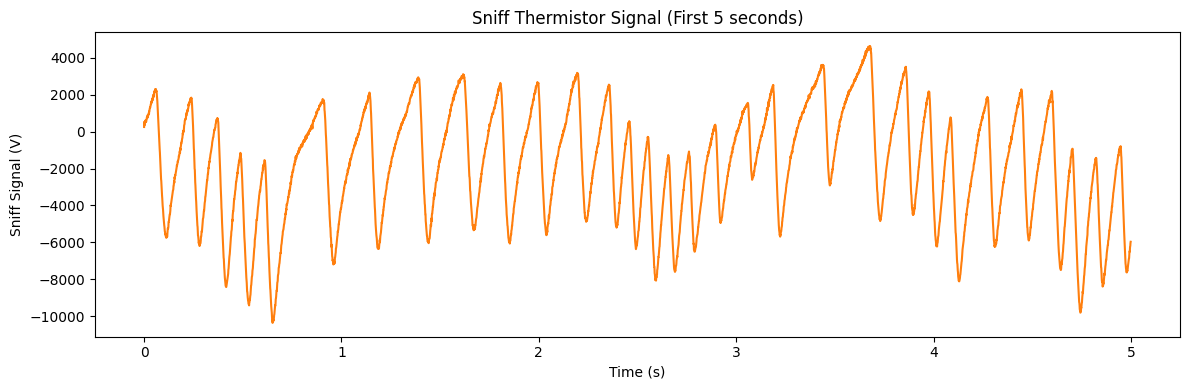

In [5]:
SniffSignal = nwb.acquisition["SniffSignal"]
sniff_data = SniffSignal.data[:num_samples]

plt.figure(figsize=(12, 4))
plt.plot(time, sniff_data, color="tab:orange")
plt.xlabel("Time (s)")
plt.ylabel("Sniff Signal (V)")
plt.title("Sniff Thermistor Signal (First 5 seconds)")
plt.tight_layout()
plt.show()

---
## Sniff Event Features: Inhalation and Exhalation Timestamps

Event times are provided under `nwb.processing["behavior"]` as "inhalation_time" and "exhalation_time".

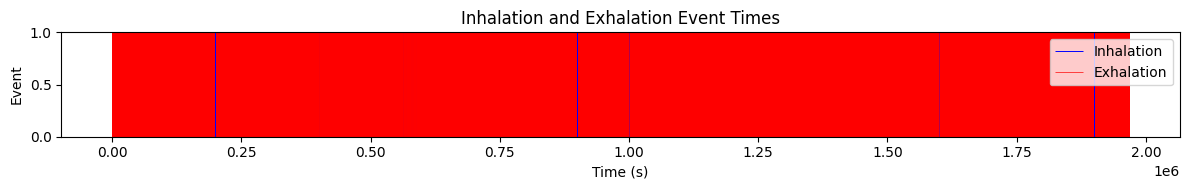

In [6]:
behavior = nwb.processing["behavior"]
inhalation = behavior.data_interfaces["inhalation_time"]
exhalation = behavior.data_interfaces["exhalation_time"]

inhalation_timestamps = inhalation.timestamps[:]
exhalation_timestamps = exhalation.timestamps[:]

plt.figure(figsize=(12, 2))
plt.vlines(inhalation_timestamps, 0, 1, label="Inhalation", color="b", linewidth=0.7)
plt.vlines(exhalation_timestamps, 0, 1, label="Exhalation", color="r", linewidth=0.7, alpha=0.7)
plt.ylim([0, 1])
plt.xlabel("Time (s)")
plt.ylabel("Event")
plt.title("Inhalation and Exhalation Event Times")
plt.legend()
plt.tight_layout()
plt.show()

---
## Combining Data: Sniff-locked LFP Segments

As an example of more advanced visualization, one can average LFP windows time-locked to inhalation events.
Here, for demonstration, we'll extract and plot average LFP segments around the first 20 inhalations for just 1 channel.

**Warning:** This is illustrative and not deeply analyzed. In actual studies, use all relevant metadata and check assumptions.

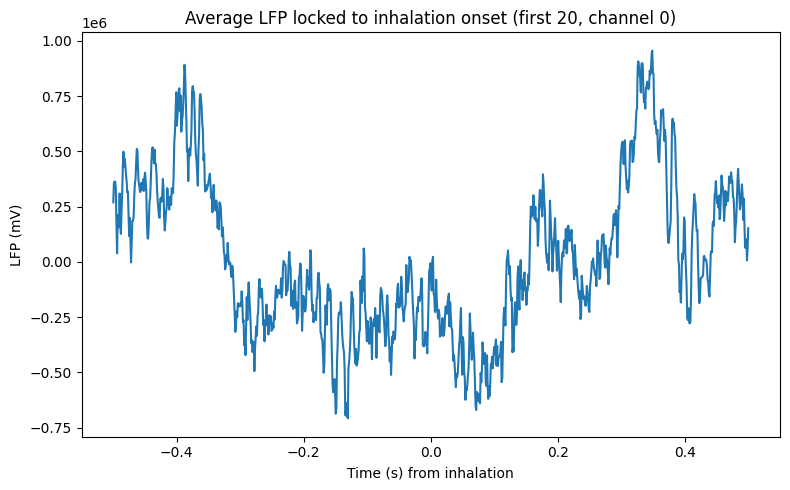

In [7]:
window = int(rate // 2)  # +/- 500 ms window (totalling ~1 sec)
chn = 0

segments = []
for t in inhalation_timestamps[:20]:  # First 20 inhalations
    idx = int(t * rate)
    # Ensure window does not exceed bounds
    if idx - window >= 0 and idx + window < LFP.data.shape[0]:
        seg = LFP.data[idx - window:idx + window, chn]
        segments.append(seg)

if segments:
    segs = np.stack(segments)
    avg = np.mean(segs, axis=0)
    t_axis = np.linspace(-0.5, 0.5, segs.shape[1])
    plt.figure(figsize=(8, 5))
    plt.plot(t_axis, avg * 1e3, label=f"Channel {electrodes_df.index[chn]}")
    plt.xlabel("Time (s) from inhalation")
    plt.ylabel("LFP (mV)")
    plt.title("Average LFP locked to inhalation onset (first 20, channel 0)")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data to compute inhalation-locked LFP averages.")

---
## Summary and Future Directions

This notebook demonstrated:

- How to remotely explore data and metadata from a DANDI published NWB file in Python
- Visualization of LFP and sniffing signals, and access to event timestamps
- Example analysis of LFP time-locked to sniff inhalations (illustrative only)

**Possible next steps:**
- More sophisticated LFP/event analysis (statistical tests, frequency analysis, etc.)
- Use of other NWB files in the Dandiset (change the assetID/path in code)
- Visualization across multiple sessions, animals, or electrodes
- Export data for downstream use in other environments or analyses

For further exploration, you can open the NWB files directly using [Neurosift](https://neurosift.app/nwb?url=https://api.dandiarchive.org/api/assets/63d19f03-2a35-48bd-a54f-9ab98ceb7be2/download/&dandisetId=001433&dandisetVersion=draft).

---

**Disclaimer:** This notebook is AI-generated and not fully verified. Scientific interpretation should be performed by a domain expert.